# Info

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

# Libraries Import

In [136]:
import glob
import cv2
import tqdm

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
import kagglehub

In [139]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [140]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Concatenate
from tensorflow.keras.layers import AvgPool2D, UpSampling2D, concatenate, Conv2DTranspose, GlobalAvgPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

In [141]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [142]:
from concurrent.futures import ThreadPoolExecutor

In [225]:
from tensorflow.keras import backend as K
K.clear_session()


# Constants

In [144]:
IMG_W = 224
IMG_H = 224

EPOCHS = 50
BATCH_SIZE = 32

VAL_SPLIT = 0.2

BASE_DIR = r'/content/drive/MyDrive/sketch_to_rgb'
# BASE_DIR = ''

# Functions

In [145]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset

In [146]:
import kagglehub

# Download latest version
path_tom_jerry = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")
print("Path to dataset files:", path_tom_jerry)
print(os.listdir(path_tom_jerry))

Path to dataset files: /kaggle/input/tom-and-jerry-image-classification
['tom_and_jerry', 'challenges.csv', 'ground_truth.csv']


# Dataset Read

In [147]:
def walk_inside_folder(folder_path):
  EXTENSIONS = ['png', 'jpeg', 'jpg']

  images_paths = []
  for root,dirs,files in os.walk(folder_path):
    for ext in EXTENSIONS:
      images_paths = images_paths + glob.glob(os.path.join(root,'*.'+ext))
  return images_paths


In [148]:
images_paths = walk_inside_folder(path_tom_jerry)

# Exploration & Visualization

In [149]:
print(f"Total images: {len(images_paths)}")

Total images: 5478


In [150]:
for i in range(13):
    print(f"Image[{i:02d}] Shape:", cv2.imread(images_paths[i]).shape)

Image[00] Shape: (480, 854, 3)
Image[01] Shape: (480, 854, 3)
Image[02] Shape: (480, 854, 3)
Image[03] Shape: (480, 854, 3)
Image[04] Shape: (480, 854, 3)
Image[05] Shape: (720, 1280, 3)
Image[06] Shape: (480, 854, 3)
Image[07] Shape: (480, 854, 3)
Image[08] Shape: (480, 854, 3)
Image[09] Shape: (480, 854, 3)
Image[10] Shape: (480, 854, 3)
Image[11] Shape: (480, 854, 3)
Image[12] Shape: (480, 854, 3)


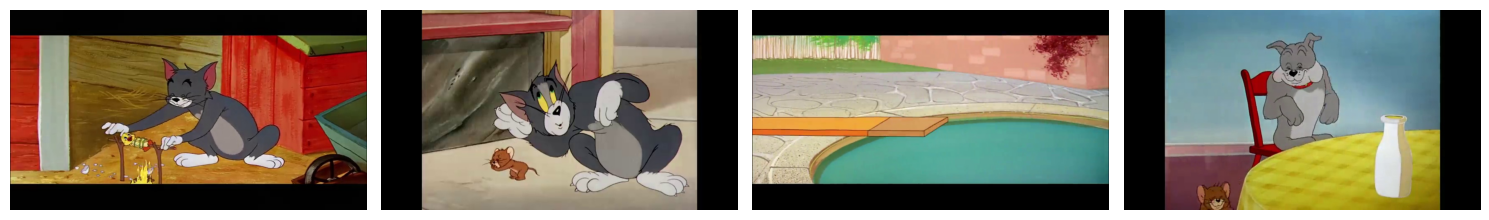

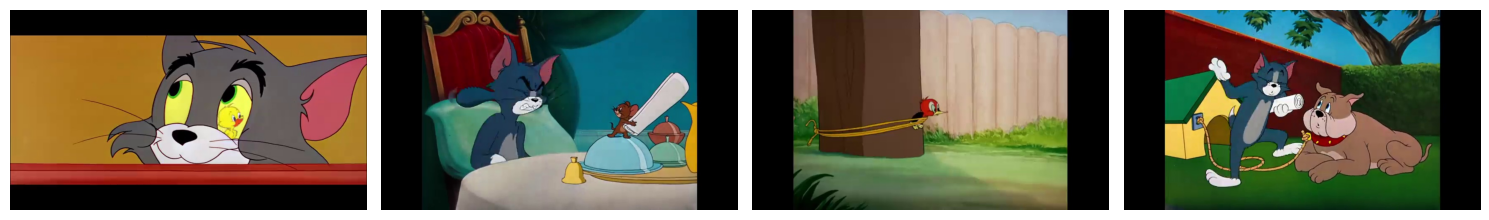

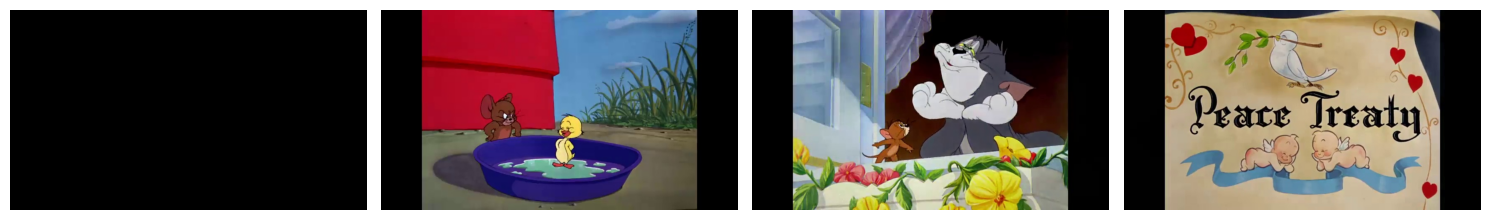

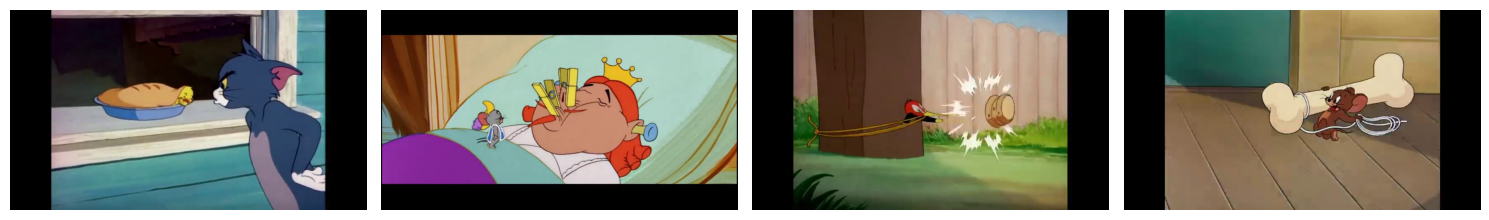

In [151]:
N_ROWS = 4
N_COLS = 4

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(15, 15))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(images_paths))
            img_path_i = images_paths[id_j]
            img_i = cv2.imread(img_path_i, 1)
            img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)

            axs[j].imshow(img_i, cmap='gray')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Images Preprocessing

Blur Filters

In [152]:
# make image smooth
def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# remove salt and pepper noise
def apply_filter_median(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# preserve edges while reducing noise
def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

In [153]:
def apply_gradient_magnitude(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(grad_x ** 2 + grad_y ** 2)

    mag_norm = cv2.normalize(mag, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) * 255

    return mag_norm.astype(image.dtype)

def apply_gradient_direction(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    direction = np.arctan2(grad_y, grad_x)

    direction_norm = (direction + np.pi) / (2 * np.pi) * 255

    return direction_norm.astype(image.dtype)

Edge Detection

In [154]:
def apply_laplacian(image, ksize=3):
    return cv2.Laplacian(image, cv2.CV_32F, ksize=ksize).astype(image.dtype)

def apply_sobel(image, dx=1, dy=0, ksize=3):
    return cv2.Sobel(image, cv2.CV_32F, dx, dy, ksize=ksize).astype(image.dtype)

def apply_canny(image, threshold1=100, threshold2=150):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

Kmeans

In [155]:
def apply_kmeans(image, n_colors = 12):
    n_channels = image.shape[2] if len(image.shape) == 3 else 1

    Z = image.reshape((-1, n_channels)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]

    clustered = res.reshape(image.shape)
    return clustered

In [156]:
def preprocess_image_from_path(image_path):
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (IMG_H, IMG_W))

    image = apply_kmeans(image)
    grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edge = apply_canny(grey_image)

    edge = np.expand_dims(edge, axis=-1)

    image = (image / 255.0).astype(np.float32)
    edge = (edge / 255.0).astype(np.float32)

    return [image, edge]

(224, 224, 3) (224, 224, 1) 0.85490197 0.003921569 1.0 0.0


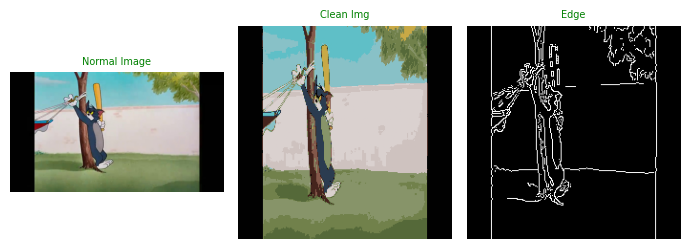

(224, 224, 3) (224, 224, 1) 0.85490197 0.0 1.0 0.0


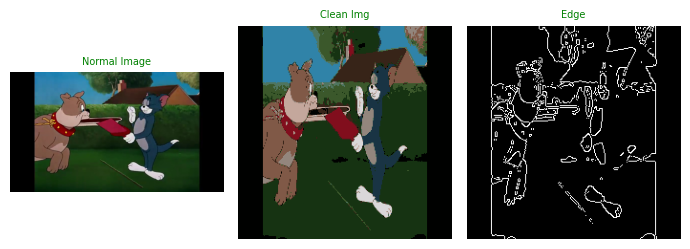

(224, 224, 3) (224, 224, 1) 0.8392157 0.0 1.0 0.0


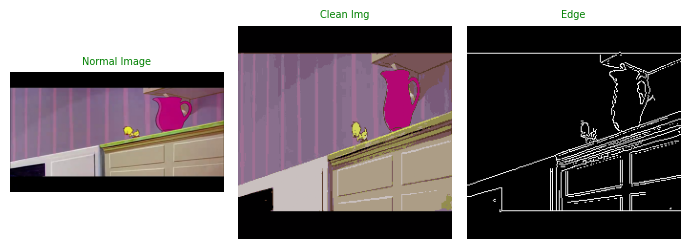

(224, 224, 3) (224, 224, 1) 0.84705883 0.0 1.0 0.0


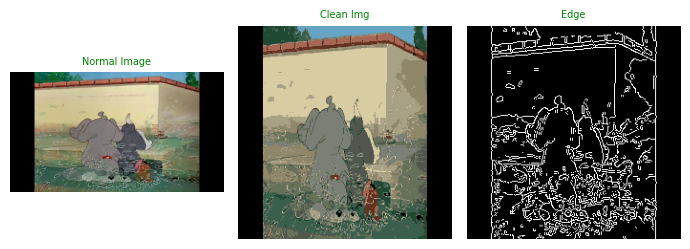

(224, 224, 3) (224, 224, 1) 0.827451 0.0 1.0 0.0


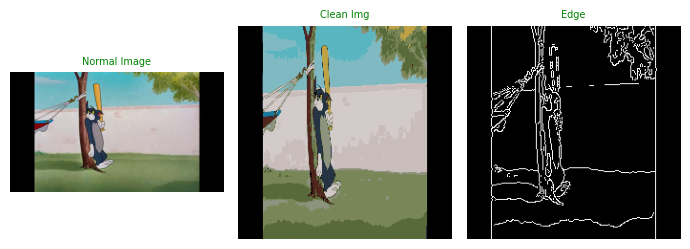

In [157]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 3, figsize=(7, 7))
    id_j = np.random.randint(0, len(images_paths))
    img_path_i = images_paths[id_j]

    img_i = cv2.imread(img_path_i, 1)
    img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)
    img_i_processed, edge_img = preprocess_image_from_path(img_path_i)

    print(img_i_processed.shape, edge_img.shape, np.max(img_i_processed), np.min(img_i_processed), np.max(edge_img), np.min(edge_img))

    axs[0].imshow(img_i.squeeze())
    axs[0].set_title(f"Normal Image", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed)
    axs[1].set_title(f"Clean Img", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(edge_img, cmap='gray')
    axs[2].set_title(f"Edge", fontsize=7, color='green')
    axs[2].axis('off')

    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [158]:
threshold = VAL_SPLIT * len(images_paths)

np.random.shuffle(images_paths)
images_paths_train = images_paths[:-int(threshold)]
images_paths_val = images_paths[-int(threshold):]

In [159]:
print(f"Train images: {len(images_paths_train)}")
print(f"Val images: {len(images_paths_val)}")

Train images: 4383
Val images: 1095


# Data Augmentation

In [160]:
def custom_augmentation_numpy(image, edge_img):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        edge_img = np.fliplr(edge_img)

    # -----------------------------
    # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)
    #     edge_img = np.flipud(edge_img)

    # -----------------------------
    # 3. Random Rotation (-15 to 15 degrees)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)
        edge_img = cv2.warpAffine(edge_img, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.9, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        edge_img = edge_img[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))
        edge_img = cv2.resize(edge_img, (w, h), interpolation=cv2.INTER_NEAREST)

    # -----------------------------
    # 5. Random Brightness (image only)
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.05, 0.05)
        image = image + brightness_shift
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 6. Random Contrast (image only)
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 7. Random Gaussian Noise (image only)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.025, image.shape)
        image = image + noise
        image = np.clip(image, 0, 1)

    if len(edge_img.shape) == 2:
      edge_img = np.expand_dims(edge_img,axis= -1)

    return image, edge_img


In [161]:
class MyDataGenerator(Sequence):
    def __init__(self, images_paths, batch_size=32, augment=True, shuffle=True, n_workers=4):
        self.images_paths = np.array(images_paths)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

        # Runtime cache
        self._image_cache = dict()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]

        batch_images_edge_pairs = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images_edge_pairs = [custom_augmentation_numpy(*img) for img in batch_images_edge_pairs]

        return np.array([x[1] for x in batch_images_edge_pairs]), np.array([x[0] for x in batch_images_edge_pairs])

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            image_edge_pairs = list(executor.map(self._load_and_preprocess_single, paths))
        return image_edge_pairs

    def _load_and_preprocess_single(self, path):
        if path in self._image_cache:
            return self._image_cache[path]
        else:
            image_edge_pair = preprocess_image_from_path(path)
            self._image_cache[path] = image_edge_pair
            return self._image_cache[path]


In [162]:
train_generator = MyDataGenerator(images_paths_train, batch_size=6, augment=True, shuffle=True)
train_pure_generator = MyDataGenerator(images_paths_train, batch_size=6, augment=False, shuffle=True)
val_generator = MyDataGenerator(images_paths_val, batch_size=BATCH_SIZE, augment=False, shuffle=False)

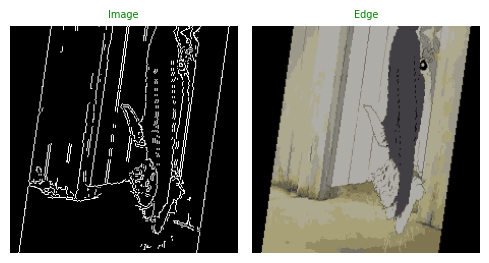

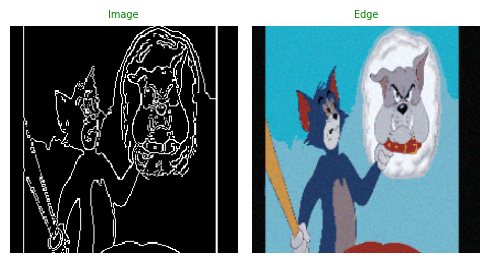

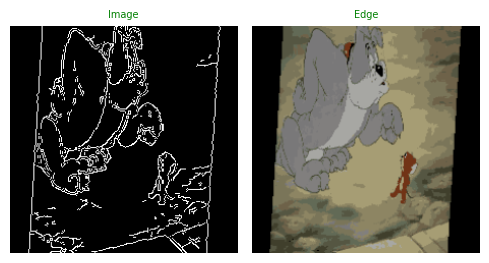

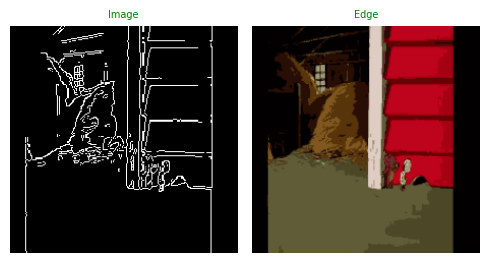

In [163]:
random_batch_x,random_batch_y  = train_generator[0]

for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Image", fontsize=7, color='green')
    axs[0].axis('off')
    axs[1].imshow(random_batch_y[i], cmap='gray')
    axs[1].set_title(f"Edge", fontsize=7, color='green')
    axs[1].axis('off')

    fig.tight_layout()
    plt.show()

# Model Encapsulation

In [249]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'models_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [250]:
class CustomModel:
    def __init__(self, name, gen_model, discrim_model, entire_model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()

        self.gen_model = gen_model
        self.discrim_model = discrim_model
        self.entire_model = entire_model

        self.y_train_hat = None
        self.y_val_hat = None
        self.y_test_hat = None
        self.trained = False

        self.load()

    def fit(self, data_gen, epochs):
        # Compile ONCE outside the loop to avoid tf retracing warning
        self.discrim_model.compile(optimizer='adam', loss='binary_crossentropy')
        self.entire_model.compile(optimizer='adam', loss='binary_crossentropy')
        self.gen_model.compile(optimizer='adam', loss='mse')

        for epoch_i in range(epochs):
            for batch_i in range(len(data_gen)):
                print(f'\nEpoch {epoch_i + 1}/{epochs}, Batch {batch_i + 1}/{len(data_gen)}')

                x_train, y_train = data_gen[batch_i]

                # -- Train Generator
                self.gen_model.trainable = True
                self.discrim_model.trainable = False

                print("Train generator")
                self.gen_model.train_on_batch(x_train, y_train)


                # --- Train Discriminator ---
                self.discrim_model.trainable = True
                self.gen_model.trainable = False

                y_pred = self.gen_model.predict(x_train, verbose=0)
                y_real = np.ones((x_train.shape[0], 1))
                y_fake = np.zeros((x_train.shape[0], 1))

                desc_x = np.concatenate([y_pred, y_train], axis=0)
                desc_y = np.concatenate([y_fake, y_real], axis=0)

                idx = np.arange(len(desc_x))
                np.random.shuffle(idx)
                desc_x = desc_x[idx]
                desc_y = desc_y[idx]

                print("Train discriminator")
                self.discrim_model.train_on_batch(desc_x, desc_y)

                # --- Train Entire Model ---
                self.discrim_model.trainable = False
                self.gen_model.trainable = True

                y_real = np.ones((x_train.shape[0], 1))

                print("Train generator through system")
                self.entire_model.train_on_batch(x_train, y_real)

            # Save weights after each epoch
            self.save()

        self.trained = True

    def load(self):
        g_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5'
        d_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5'


        # Build generator
        _ = self.gen_model(tf.zeros((1, IMG_H, IMG_W, 1)))

        # Build discriminator directly, NOT via entire model
        _ = self.discrim_model(tf.zeros((1, IMG_H, IMG_W, 3)))

        # Build entire model (optional, but harmless)
        _ = self.entire_model(tf.zeros((1, IMG_H, IMG_W, 1)))

        if os.path.exists(g_file_path) and os.path.exists(d_file_path):
            self.gen_model.load_weights(g_file_path)
            self.discrim_model.load_weights(d_file_path)
            self.trained = True
            print(f'Model {self.name} weights loaded from cache')
        else:
            self.trained = False

    def save(self):
        self.gen_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5')
        self.discrim_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5')


# Models Arch

In [251]:
models_list = list()

In [252]:
def build_model_1():
    global models_list
    NAME = 'gan_unet_v1'

    gan_inputs = Input((IMG_H, IMG_W, 1))

    # Encoder
    c1 = Conv2D(32, (3, 3), padding='same')(gan_inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(32, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(64, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)


    # Bottleneck
    b = Conv2DTranspose(128, (3, 3), padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(128, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder

    u3 = Conv2DTranspose(64, (4, 4), strides=2, padding='same')(b)
    u3 = Conv2D(64, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = concatenate([u3, c2])
    c7 = Conv2D(64, (3, 3), padding='same')(u3)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(64, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u4 = Conv2DTranspose(32, (4, 4), strides=2, padding='same')(c7)
    u4 = Conv2D(32, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = concatenate([u4, c1])
    c8 = Conv2D(32, (3, 3), padding='same')(u4)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(32, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    outputs = Conv2D(3, (1,1), activation='sigmoid') (c8)

    gen_model = Model(inputs=[gan_inputs], outputs=[outputs])

    gen_model.compile(optimizer='adam', loss='mse')

    gen_model.summary()


    # Discriminator
    descrim_input = Input((IMG_H, IMG_W, 3))
    d = Conv2D(32, (3, 3), padding='same')(descrim_input)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    d = MaxPooling2D((2, 2))(d)

    d = Conv2D(64, (3, 3), strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    d = MaxPooling2D()(d)

    d = Conv2D(128, (3, 3), strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    d = GlobalAvgPool2D()(d)

    d = Flatten()(d)
    d = Dense(32, activation='relu')(d)

    d = Dense(1, activation='sigmoid')(d)

    descrim_model = Model(inputs=[descrim_input], outputs=[d])

    descrim_model.compile(optimizer='adam', loss='binary_crossentropy')

    descrim_model.summary()

    # Entire Model
    all_gan_input = Input(shape=(IMG_H, IMG_W, 1))
    all_gen_out = gen_model(all_gan_input)
    all_discrim_out = descrim_model(all_gen_out)
    entire_model = Model(inputs=all_gan_input, outputs=all_discrim_out)
    entire_model.compile(optimizer='adam', loss='binary_crossentropy')

    custom_model =  CustomModel(NAME, gen_model, descrim_model, entire_model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)


build_model_1()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 224, 224,  │        320 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_75       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_75[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_76       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 112, 112,  │          0 │ activation_76[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_77       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_77[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_78       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 56, 56,    │          0 │ activation_78[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_15 │ (None, 56, 56,    │     73,856 │ max_pooling2d_21… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_transpose

 Total params: 638,019 (2.43 MB)

 Trainable params: 636,547 (2.43 MB)

 Non-trainable params: 1,472 (5.75 KB)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_87 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_88 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_89 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,305 (384.00 KB)

 Trainable params: 97,857 (382.25 KB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_315']
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_359']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Model gan_unet_v1 weights loaded from cache


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 110 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [253]:
for model in models_list:

        plot_model(
            model.gen_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_gen_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )

        plot_model(
            model.discrim_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_descrim_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )


# Model Training

In [ ]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator, epochs= 10)
    print('\n')

1. Train: gan_unet_v1

Epoch 1/10, Batch 1/731
Train generator


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_315']
Received: inputs=Tensor(shape=(6, 224, 224, 1))
  warnings.warn(msg)


Train discriminator


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_359']
Received: inputs=Tensor(shape=(12, 224, 224, 3))
  warnings.warn(msg)


Train generator through system

Epoch 1/10, Batch 2/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 3/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 4/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 5/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 6/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 7/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 8/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 9/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 10/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 11/731
Train generator
Train discriminator
Train generator through system

Epoch 1/10, Batch 12/731
Train generator
Train

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_315']
Received: inputs=Tensor(shape=(None, 224, 224, 1))
  warnings.warn(msg)


Train discriminator


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_359']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


Train generator through system

Epoch 2/10, Batch 1/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 2/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 3/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 4/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 5/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 6/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 7/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 8/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 9/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 10/731
Train generator
Train discriminator
Train generator through system

Epoch 2/10, Batch 11/731
Train generator
Train 

In [ ]:
# for i, model in enumerate(models_list):
#     print(f"{i+1}. Train: {model.name}")
#     model.save()
#     print('\n')

# Model Eval

In [ ]:
TEST_DIR_PATH = os.path.join(BASE_DIR,'test')
os.makedirs(TEST_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y  = val_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i])
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i])
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TEST_DIR_PATH, f'test sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

In [ ]:
TRAIN_DIR_PATH = os.path.join(BASE_DIR,'train')
os.makedirs(TRAIN_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y = train_pure_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i], cmap='gray')
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i], cmap='gray')
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TRAIN_DIR_PATH, f'train sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

# Depolyment